In [9]:

!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple/ opencv-contrib-python
!pip install SimpleITK


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


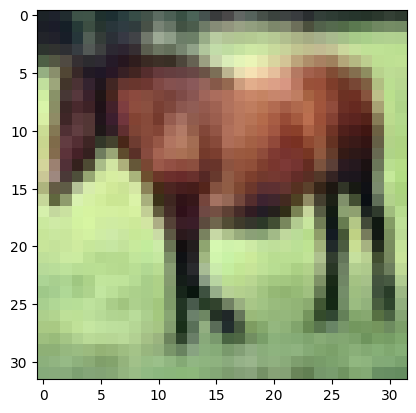

In [13]:
import cv2
import matplotlib.pyplot as plt
filepath='/kaggle/input/cifar10-pngs-in-folders/cifar10/train/horse/0001.png'

image = cv2.imread(filepath)

# 将图像从 BGR 转换为 RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [14]:
from numpy.linalg import inv
def _invertAffineTransform(matrix):
    """cv.invertAffineTransform(). 本质是求逆

    :param matrix: shape[2, 3]. float32
    :return: shape[2, 3]
    """
    matrix = np.concatenate([matrix, np.array([0, 0, 1], dtype=matrix.dtype)[None]])  # for求逆
    return inv(matrix)[:2]

def _warpAffine(x, matrix, dsize=None, flags=None):
    """cv.warpAffine(borderMode=None, borderValue=(114, 114, 114))

    :param x: shape[H, W, C]. uint8
    :param matrix: 仿射矩阵. shape[2, 3]. float32
    :param dsize: Tuple[W, H]. 输出的size
    :param flags: cv.WARP_INVERSE_MAP. 唯一可选参数
    :return: shape[dsize[1], dsize[0], C]. uint8
    """
    dsize = dsize or (x.shape[1], x.shape[0])  # 输出的size
    borderValue = np.array((114, 114, 114), dtype=x.dtype)  # 背景填充
    if flags is None or flags & cv.WARP_INVERSE_MAP == 0:  # flags无cv.WARP_INVERSE_MAP参数
        matrix = _invertAffineTransform(matrix)
    grid_x, grid_y = np.meshgrid(np.arange(dsize[0]), np.arange(dsize[1]))  # np.int32
    src_x = (matrix[0, 0] * grid_x + matrix[0, 1] * grid_y + matrix[0, 2]).round().astype(np.int32)  # X
    src_y = (matrix[1, 0] * grid_x + matrix[1, 1] * grid_y + matrix[1, 2]).round().astype(np.int32)  # Y
    src_x_clip = np.clip(src_x, 0, x.shape[1] - 1)  # for索引合法
    src_y_clip = np.clip(src_y, 0, x.shape[0] - 1)
    output = np.where(((0 <= src_x) & (src_x < x.shape[1]) & (0 <= src_y) & (src_y < x.shape[0]))[:, :, None],
                      x[src_y_clip, src_x_clip], borderValue[None, None])  # 广播机制
    return output





/tmp/ipykernel_33/1607314971.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  low_ox = int(np.floor(ox)) # 向下取整
/tmp/ipykernel_33/1607314971.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  low_oy = int(np.floor(oy)) # 向下取整


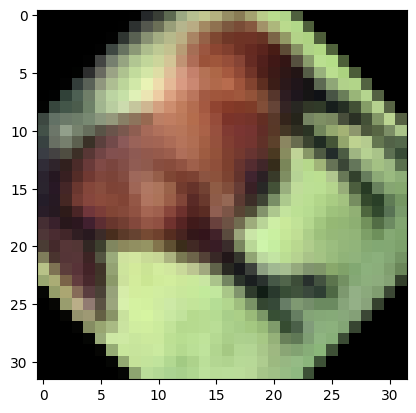

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import *
def pyWarpAffine(image, M, dst_size, constant=(0,0,0)):
    M = cv2.invertAffineTransform(M) # 求仿射变换的逆矩阵，因为我们是把目的图片作为输入图片，因此需要使用逆矩阵求取原始图片的点
    constant = np.array(constant)
    ih,iw = image.shape[:2]
    dw,dh = dst_size
    dst = np.full((dh,dw,3), constant, dtype=np.uint8)
    irange = lambda p:p[0]>=0 and p[0]<iw and p[1]>=0 and p[1]<ih  # 边界判断
    for y in range(dh):
        for x in range(dw):
            # 构造一个齐次矩阵
            homogeneous = np.array([[x,y,1]]).T # 一个列矩阵
            ox, oy = M @ homogeneous # 把目标的点仿射变换为原始图像的点
            low_ox = int(np.floor(ox)) # 向下取整
            low_oy = int(np.floor(oy)) # 向下取整
            high_ox = low_ox + 1 # 向上取整
            high_oy = low_oy + 1 # 向上取整
            # 双线性插值
            # p0        p1
            #       0
            # p2        p3
            # 针对图片来说
            pos = ox - low_ox, oy - low_oy # 获取相对位置
            p0_area = (1 - pos[0]) * (1 - pos[1])
            p1_area = pos[0] * (1 - pos[1])
            p2_area = (1 - pos[0]) * pos[1]
            p3_area = pos[0] * pos[1]
            
            p0 = low_ox, low_oy
            p1 = high_ox, low_oy
            p2 = low_ox, high_oy
            p3 = high_ox, high_oy
#             print(image[p0[1], p0[0]])
            
            p0_value = image[p0[1], p0[0]] if irange(p0) else constant
            p1_value = image[p1[1], p1[0]] if irange(p1) else constant
            p2_value = image[p2[1], p2[0]] if irange(p2) else constant
            p3_value = image[p3[1], p3[0]] if irange(p3) else constant
            dst[y, x] = p0_area * p0_value + p1_area * p1_value + p2_area * p2_value + p3_area * p3_value

    return dst
# 旋转角
angle=45
# x平移和y平移
dx=8
dy=8
h, w = image.shape[:2]
center = (w / 2, h / 2)
M=cv2.getRotationMatrix2D(center, angle, 1)

new_H = int(w * fabs(sin(radians(angle))) + h * fabs(cos(radians(angle))))
new_W = int(h * fabs(sin(radians(angle))) + w * fabs(cos(radians(angle))))
# M[0, 2] += dx
# M[1, 2] += dy
acat1_py = pyWarpAffine(image, M, (32, 32))
plt.imshow(acat1_py)

# 旋转角
angle=20
# x平移和y平移
dx=8
dy=8

center = (w / 2, h / 2)
M2=cv2.getRotationMatrix2D(center, angle, 1)
acat2_py = pyWarpAffine(image, M2, (32, 32))

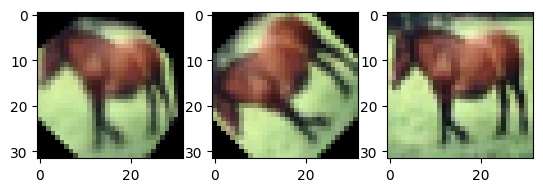

In [41]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
 
 
img2 = image  # referenceImage
img1 = acat1_py # sensedImage
 
 
# Initiate SIFT detector
sift_detector = cv.SIFT_create()
# Find the keypoints and descriptors with SIFT
kp1, des1 = sift_detector.detectAndCompute(img1, None)
kp2, des2 = sift_detector.detectAndCompute(img2, None)
 
 
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
 
 
# Filter out poor matches
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
 
 
matches = good_matches
        
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
 
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
 
 
# Find homography
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
 
# Warp image 1 to align with image 2
img1Reg = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
plt.subplot(1,3,1)
plt.imshow(img1Reg)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.subplot(1,3,3)
plt.imshow(img2)
# The problem is that this matrix H is found via a compute-intensive optimization process.

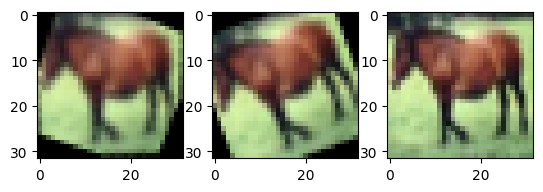

In [43]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
 
 
img2 = image  # referenceImage
img1 = acat2_py # sensedImage
 
 
# Initiate SIFT detector
sift_detector = cv.SIFT_create()
# Find the keypoints and descriptors with SIFT
kp1, des1 = sift_detector.detectAndCompute(img1, None)
kp2, des2 = sift_detector.detectAndCompute(img2, None)
 
 
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
 
 
# Filter out poor matches
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
 
 
matches = good_matches
        
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
 
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
 
 
# Find homography
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
 
# Warp image 1 to align with image 2
img2Reg = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
plt.subplot(1,3,1)
plt.imshow(img2Reg)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.subplot(1,3,3)
plt.imshow(img2)
# The problem is that this matrix H is found via a compute-intensive optimization process.

L1 loss: 50.6813
L1 loss: 28.0729


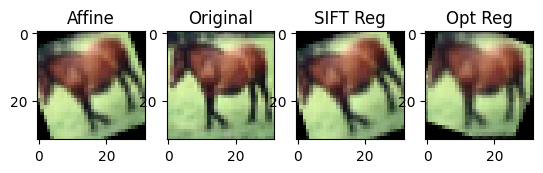

In [50]:
import cv2
import numpy as np

def calculate_l1_loss(img1, img2):
    """
    计算两个RGB图像的L1 loss,忽略黑色填充像素
    """
    # 检查图像尺寸是否一致
#     assert img1.shape == img2.shape

    # 计算绝对差
    diff = np.abs(img1.astype(np.float32) - img2.astype(np.float32))

    # 忽略黑色填充像素
    mask = np.all(img1 == 0, axis=2) & np.all(img2 == 0, axis=2)
    diff[mask] = 0

    # 计算L1 loss
    l1_loss = np.mean(diff)

    return l1_loss


# 计算L1 loss
# print(img1Reg)
l1_loss = calculate_l1_loss(img1Reg, img2)
print(f"L1 loss: {l1_loss:.4f}")
l1_loss = calculate_l1_loss(img2Reg, img2)
print(f"L1 loss: {l1_loss:.4f}")
plt.subplot(1,4,1)
plt.imshow(img1)
plt.title('Affine')
plt.subplot(1,4,2)
plt.imshow(img2)
plt.title('Original')
plt.subplot(1,4,3)
plt.imshow(img1Reg)
plt.title('SIFT Reg')
plt.subplot(1,4,4)
plt.title('Opt Reg')
plt.imshow(img2Reg)

[[ 0.70710678  0.70710678 -6.627417  ]
 [-0.70710678  0.70710678 16.        ]]


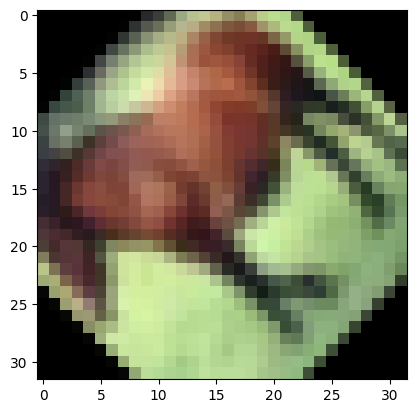

In [61]:
import numpy as np
from numpy.linalg import inv
def _invertAffineTransform(matrix):
    """cv.invertAffineTransform(). 本质是求逆

    :param matrix: shape[2, 3]. float32
    :return: shape[2, 3]
    """
    matrix = np.concatenate([matrix, np.array([0, 0, 1], dtype=matrix.dtype)[None]])  # for求逆
    return inv(matrix)[:2]

# 旋转角
angle=45
# x平移和y平移
dx=8
dy=8
h, w = image.shape[:2]
center = (w / 2, h / 2)
M=cv2.getRotationMatrix2D(center, angle, 1)

new_H = int(w * fabs(sin(radians(angle))) + h * fabs(cos(radians(angle))))
new_W = int(h * fabs(sin(radians(angle))) + w * fabs(cos(radians(angle))))
# M[0, 2] += (new_W - w) / 2
# M[1, 2] += (new_H - h) / 2
# print(M)

# dsize = (32,32)
# borderValue = np.array((0, 0, 0))  # 背景填充
# matrix = _invertAffineTransform(M)
# matrix=M
# print(matrix)

# grid_x, grid_y = np.meshgrid(np.arange(dsize[0]), np.arange(dsize[1]))
# print(grid_y)
# ox = (matrix[0, 0] * grid_x + matrix[0, 1] * grid_y + matrix[0, 2])  # X
# oy = (matrix[1, 0] * grid_x + matrix[1, 1] * grid_y + matrix[1, 2])  # Y
# print(ox.shape)

# low_ox=np.int32(np.floor(ox))
# low_oy=np.int32(np.floor(oy))
# high_ox=low_ox+1
# high_oy=low_oy+1
# print(low_ox.shape,high_ox.shape)


# s1=(ox-low_ox)*(oy-low_oy)
# s2=(high_ox-ox)*(oy-low_oy)
# s3=(ox-low_ox)*(high_oy-oy)
# s4=(high_ox-ox)*(high_oy-oy)
# print(s1.shape)

# dst=np.zeros(image.shape)
# a=image[0,0,:]
# print(dst.shape)


# rotate = cv2.warpAffine(image, M, (new_W, new_H), borderValue=(0, 0, 0))
rotate = cv2.warpAffine(image, M, (w,h), borderValue=(0, 0, 0))
print(M)
plt.imshow(rotate) #RGB

In [62]:
img1=image
img2=rotate

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device='cpu'
# 假设 img1 和 img2 已经加载，形状为 (32, 32, 3)
img1 = torch.tensor(image, requires_grad=False, dtype=torch.float32).permute(2, 0, 1).to(device)
img2 = torch.tensor(acat1_py, requires_grad=False, dtype=torch.float32).permute(2, 0, 1).to(device)


# 初始化参数
angle = torch.tensor(5.0, requires_grad=True)
dx = torch.tensor(0.0, requires_grad=True)
dy = torch.tensor(0.0, requires_grad=True)

def forward(image, M, dst_size=(32, 32), constant=(0, 0, 0)):
    # 确保输入图像形状为 (C, H, W)
    assert len(image.shape) == 3, "输入图像必须为形状 (C, H, W) 的张量"
    
    C, H, W = image.shape
    dst_W, dst_H = dst_size
    
    # 逆仿射变换矩阵
    M_inv = torch.inverse(torch.cat((M, torch.tensor([[0, 0, 1]], dtype=M.dtype, device=M.device)), dim=0))[:2, :]
    
    # 生成目标图像的网格
    grid_x, grid_y = torch.meshgrid(torch.arange(dst_W, dtype=M.dtype, device=M.device),
                                    torch.arange(dst_H, dtype=M.dtype, device=M.device))
    grid = torch.stack((grid_x, grid_y, torch.ones_like(grid_x)), dim=-1).view(-1, 3)
    
    # 将目标图像的网格点应用逆仿射变换
    src_coords = grid @ M_inv.t()
    src_coords = src_coords.view(dst_H, dst_W, 2)
    
    # 归一化坐标到 [-1, 1]，以便使用 F.grid_sample
    src_coords[..., 0] = 2 * src_coords[..., 0] / (W - 1) - 1
    src_coords[..., 1] = 2 * src_coords[..., 1] / (H - 1) - 1
    
    # 将坐标转换为 (dst_H, dst_W, 2) 的张量
    src_coords = src_coords.unsqueeze(0)
    
    # 使用 F.grid_sample 进行双线性插值
    dst_image = F.grid_sample(image.unsqueeze(0), src_coords, mode='bilinear', padding_mode='zeros', align_corners=True)
    
    # 处理填充区域
    mask = ((src_coords[..., 0] >= -1) & (src_coords[..., 0] <= 1) &
            (src_coords[..., 1] >= -1) & (src_coords[..., 1] <= 1)).float()
    mask = mask.unsqueeze(0).unsqueeze(0)
    constant = torch.tensor(constant, dtype=image.dtype, device=image.device).view(1, C, 1, 1)
    dst_image = dst_image * mask + constant * (1 - mask)
    
    return dst_image.squeeze(0)

def Rigid_Loss(img1, img2):
    l1_loss = nn.L1Loss()
    return l1_loss(img1, img2)

def get_rotation_matrix(center, angle, scale=1.0):
    center = torch.tensor(center, dtype=torch.float32, requires_grad=False)
    alpha = torch.cos(torch.deg2rad(angle)) * scale
    beta = torch.sin(torch.deg2rad(angle)) * scale

    M = torch.stack([
        torch.stack([alpha, beta, (1 - alpha) * center[0] - beta * center[1]]),
        torch.stack([-beta, alpha, beta * center[0] + (1 - alpha) * center[1]])
    ])
#     print(M)
    return M


# Define the loss function and optimizer
optimizer = torch.optim.SGD([angle, dx, dy], lr=1)
num_epochs = 10000

for epoch in range(num_epochs):
    # Forward pass
    center = (w / 2, h / 2)
    M=get_rotation_matrix(center, angle, 1)
    output = forward(img2,M).reshape((32,32,3))
    print(output.size())
    loss = Rigid_Loss(output, img1)
    # Backward pass and parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch ) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#         print(output)
        print(angle)

# Final model
print(angle, dx, dy)

torch.Size([32, 32, 3])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([3, 32, 32])) that is different to the input size (torch.Size([32, 32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 2

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 假设已经加载了图像img1和img2
img1 = torch.tensor(image, requires_grad=True, dtype=torch.float32).to(device)
img2 = torch.tensor(acat1_py, requires_grad=True, dtype=torch.float32).to(device)


class Rotation(nn.Module):
    def forward(img2, M, dst_size, constant=(0,0,0)):
        

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 4096*8, dtype=torch.float32)
        self.fc2 = nn.Linear(4096*8, 1024*8, dtype=torch.float32)
        self.fc3 = nn.Linear(1024*8, 32 * 32*3, dtype=torch.float32)
#         self.fc4 = nn.Linear(32 * 32*3*16, 32 * 32*3, dtype=torch.float32)
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
        x = self.fc3(x)
        x = x.view(32, 32, 3)
        return x

def Rigid_Loss(img1, img2):
        a2 = torch.sum(img2, dim=2)
        mask = a2.bool().float()
        img1[:,:,0]=img1[:,:,0]*mask
        img1[:,:,1]=img1[:,:,1]*mask
        img1[:,:,2]=img1[:,:,2]*mask
        l1_loss = nn.L1Loss(reduction='mean')
        return l1_loss(img1,img2)

# 创建模型实例
model = MLP()
# 定义损失函数和优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# 训练
num_epochs = 1000
for epoch in range(num_epochs):
    # 前向传播
    output = model(img1)
#     print(output.size())
#     print(img2.size())
    loss = Rigid_Loss(output, img2)  
    # 反向传播和参数更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 最终的模型
print(model)